Allocation Results:
         Day  HomeID  ElectricityUsage(kWh)  CurrentWaterLevel(L)  \
0 2024-08-01       1              24.981605                  1000   
1 2024-08-01       2              48.028572                  1000   
2 2024-08-01       3              39.279758                  1000   
3 2024-08-01       4              33.946339                  1000   
4 2024-08-01       5              16.240746                   705   
5 2024-08-02       1              16.239781                  1186   
6 2024-08-02       2              12.323344                  1492   
7 2024-08-02       3              44.647046                  1225   
8 2024-08-02       4              34.044600                  1058   
9 2024-08-02       5              38.322903                  1966   

   PumpedWater(L)  WaterNeeded(L)  
0             661               0  
1             909               0  
2             634               0  
3              45               0  
4             251             295  
5   

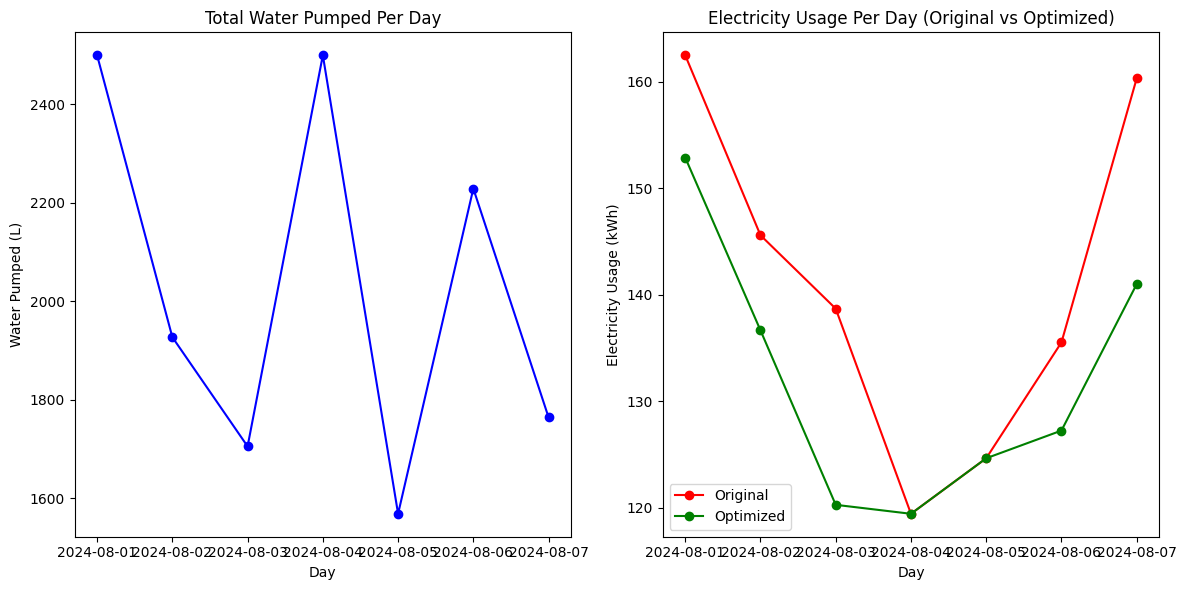

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set up random seed for reproducibility
np.random.seed(42)

# Parameters
num_homes = 5
tank_capacity = 1000  # Each home's tank capacity in liters

# Generate sample data for 7 days (1 week)
days = pd.date_range(start="2024-08-01", end="2024-08-07", freq="D")

# Simulate electricity consumption (kWh) for each home
data = {
    "Day": np.repeat(days, num_homes),
    "HomeID": np.tile(range(1, num_homes + 1), len(days)),
    "ElectricityUsage(kWh)": np.random.uniform(10, 50, size=len(days) * num_homes),
}

df = pd.DataFrame(data)

# Function to simulate sensor readings for water level
def simulate_sensor_readings(num_homes, tank_capacity):
    return np.random.randint(0, tank_capacity, size=num_homes)

# Initialize water levels based on simulated sensor readings
initial_water_level = simulate_sensor_readings(num_homes, tank_capacity)
df["CurrentWaterLevel(L)"] = np.tile(initial_water_level, len(days))

# Function to calculate water needed for each home
def calculate_water_needed(df, tank_capacity):
    df["WaterNeeded(L)"] = tank_capacity - df["CurrentWaterLevel(L)"]
    df["WaterNeeded(L)"] = df["WaterNeeded(L)"].clip(lower=0)  # Ensure no negative values
    return df

# Revised Round-Robin Water Allocation Algorithm with Sensor Integration
def round_robin_allocation(df, daily_water_supply, simulate_sensor_readings):
    homes = df["HomeID"].unique()
    
    # Initialize PumpedWater column
    df["PumpedWater(L)"] = 0
    
    for day in df["Day"].unique():
        available_water = daily_water_supply

        # Update water levels based on sensor readings for the current day
        current_sensor_readings = simulate_sensor_readings(len(homes), tank_capacity)
        df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] = current_sensor_readings

        # Calculate water needed based on updated sensor readings
        df = calculate_water_needed(df, tank_capacity)

        while available_water > 0:
            for home in homes:
                home_water_needed = df.loc[(df["Day"] == day) & (df["HomeID"] == home), "WaterNeeded(L)"].values[0]
                allocation = min(available_water, home_water_needed)
                df.loc[(df["Day"] == day) & (df["HomeID"] == home), "PumpedWater(L)"] = allocation
                available_water -= allocation
                if available_water <= 0:
                    break

            # Update current water level after allocation
            df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] += df.loc[df["Day"] == day, "PumpedWater(L)"].astype(np.int32)

    return df

# Assuming daily water supply is 2500 liters
daily_water_supply = 2500
df_allocated = round_robin_allocation(df, daily_water_supply, simulate_sensor_readings)

# Preview the allocation results
print("Allocation Results:")
print(df_allocated.head(10))

# Energy Efficiency Optimization Algorithm
def energy_efficiency_optimization(df):
    # Scale electricity usage to identify peaks
    scaler = MinMaxScaler()
    df["ScaledElectricityUsage"] = scaler.fit_transform(df[["ElectricityUsage(kWh)"]])

    # Identify peak usage periods (scaled value > 0.8)
    df["PeakUsage"] = df["ScaledElectricityUsage"] > 0.8

    # Shift peak loads to off-peak periods by reducing usage by 20% during peaks
    df["OptimizedElectricityUsage(kWh)"] = df["ElectricityUsage(kWh)"]
    df.loc[df["PeakUsage"], "OptimizedElectricityUsage(kWh)"] = df["ElectricityUsage(kWh)"] * 0.8

    return df

# Apply energy efficiency optimization
df_optimized = energy_efficiency_optimization(df_allocated)

# Preview the optimization results
print("Optimization Results:")
print(df_optimized.head(10))

# Summary and Visualization
# Summarize water pumping and electricity usage
allocation_summary = df_optimized.groupby("Day").agg(
    {"PumpedWater(L)": "sum", "ElectricityUsage(kWh)": "sum", "OptimizedElectricityUsage(kWh)": "sum"}
)

# Plot the results
plt.figure(figsize=(12, 6))

# Water Pumping
plt.subplot(1, 2, 1)
plt.plot(allocation_summary.index, allocation_summary["PumpedWater(L)"], marker='o', color='blue')
plt.title('Total Water Pumped Per Day')
plt.xlabel('Day')
plt.ylabel('Water Pumped (L)')

# Electricity Usage
plt.subplot(1, 2, 2)
plt.plot(allocation_summary.index, allocation_summary["ElectricityUsage(kWh)"], marker='o', label='Original', color='red')
plt.plot(allocation_summary.index, allocation_summary["OptimizedElectricityUsage(kWh)"], marker='o', label='Optimized', color='green')
plt.title('Electricity Usage Per Day (Original vs Optimized)')
plt.xlabel('Day')
plt.ylabel('Electricity Usage (kWh)')
plt.legend()

plt.tight_layout()
plt.show()


1. Import Libraries and Prepare Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Sample data preparation (assuming df_optimized has historical data)
# Features include 'Day', 'ElectricityUsage(kWh)', and 'PumpedWater(L)'
df = df_optimized.copy()

# Converting 'Day' to ordinal values for easier modeling
df['Day'] = pd.to_datetime(df['Day']).map(lambda date: date.toordinal())

2.Handle Missing Values

In [3]:
# Check for NaNs in target variable
print("NaNs in target variable:", df['PumpedWater(L)'].isna().sum())

# Remove rows with NaNs in target variable
df_cleaned = df.dropna(subset=['PumpedWater(L)'])

# Re-define features and target
features = ['Day', 'ElectricityUsage(kWh)']
target = 'PumpedWater(L)'

X = df_cleaned[features]
y = df_cleaned[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute NaNs if necessary (for general robustness)
imputer = SimpleImputer(strategy='mean')
y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = imputer.transform(y_test.values.reshape(-1, 1)).ravel()


NaNs in target variable: 0


3. Train Stacking Model

In [4]:
# Stacking model setup
base_models = [
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
meta_model = Ridge()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Training the model
stacking_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = stacking_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 231.1632253162148


4. Predict Future Water Usage

In [5]:
# Future prediction
future_days = pd.date_range(start="2024-08-08", end="2024-08-14", freq="D")
future_data = pd.DataFrame({
    'Day': future_days.map(lambda date: date.toordinal()),
    'ElectricityUsage(kWh)': np.random.uniform(10, 50, len(future_days))  # Replace with more accurate estimates if available
})

# Predict future water usage
future_predictions = stacking_model.predict(future_data)
future_data['PredictedWaterUsage(L)'] = future_predictions

# Display predictions
print(future_data)


      Day  ElectricityUsage(kWh)  PredictedWaterUsage(L)
0  739106              13.539700              302.577075
1  739107              17.839314              173.486012
2  739108              11.809092              245.025183
3  739109              23.013213              602.557055
4  739110              25.547092              325.738361
5  739111              20.853961              144.998919
6  739112              43.149500              460.136589


5. Visualize Future Predictions

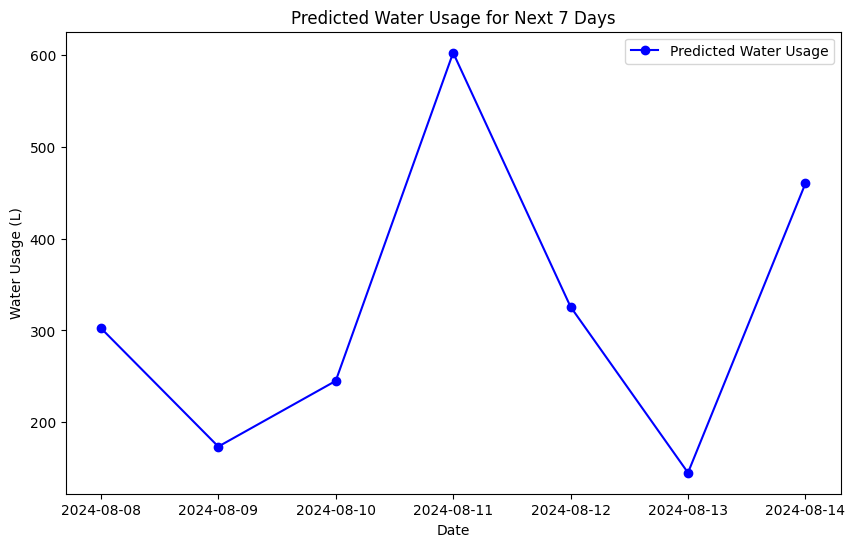

In [6]:
# Visualization of future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_days, future_predictions, marker='o', color='blue', label='Predicted Water Usage')
plt.title('Predicted Water Usage for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Water Usage (L)')
plt.legend()
plt.show()


6. Define and Apply Round-Robin Allocation

In [7]:
# Round-robin allocation algorithm
def round_robin_allocation(df, daily_water_supply, simulate_sensor_readings):
    days = df['Day'].unique()
    homes = df['HomeID'].unique()
    
    # Initialize the PumpedWater column
    df['PumpedWater(L)'] = 0
    
    for day in days:
        available_water = daily_water_supply
        daily_data = df[df['Day'] == day]
        
        if simulate_sensor_readings:
            # Simulate sensor readings here
            pass
        
        for home in homes:
            home_data = daily_data[daily_data['HomeID'] == home]
            home_water_needed = home_data['WaterNeeded(L)'].sum()
            
            allocation = min(available_water, home_water_needed)
            df.loc[(df['Day'] == day) & (df['HomeID'] == home), 'PumpedWater(L)'] = allocation
            available_water -= allocation
            if available_water <= 0:
                break
    
    return df

# Assuming daily water supply is 2500 liters
daily_water_supply = 2500
simulate_sensor_readings = False  # Set to True if you want to simulate sensor readings
df_allocated = round_robin_allocation(df_cleaned, daily_water_supply, simulate_sensor_readings)
